# Employee Burnout Analysis

Load important librearies

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from typing import Dict

from copy import deepcopy

# Data Analysis

Load the file "Employess_detail" ,which contain all the info about the Employees.

In [2]:
pf = pd.read_csv(r"Empoyees\employee_details.csv")
pf.columns = [c.replace(' ', '_') for c in pf.columns]
pf.head() 

,Employee_ID,Date_of_Joining,Gender,Company_Type,WFH_Setup_Available,Designation,Resource_Allocation,Mental_Fatigue_Score,Burn_Rate
0,fffe32003000360033003200,30-09-2008,Female,Service,No,2,3.0,3.8,0.16
1,fffe3700360033003500,30-11-2008,Male,Service,Yes,1,2.0,5.0,0.36
2,fffe31003300320037003900,10-03-2008,Female,Product,Yes,2,NaN,5.8,0.49
3,fffe32003400380032003900,03-11-2008,Male,Service,Yes,1,1.0,2.6,0.20
4,fffe31003900340031003600,24-07-2008,Female,Service,No,3,7.0,6.9,0.52


In [3]:
pf.columns

Index(['Employee_ID', 'Date_of_Joining', 'Gender', 'Company_Type',
       'WFH_Setup_Available', 'Designation', 'Resource_Allocation',
       'Mental_Fatigue_Score', 'Burn_Rate'],
      dtype='object')

In [4]:
pf.isna().sum()

Employee_ID                0
Date_of_Joining            0
Gender                     0
Company_Type               0
WFH_Setup_Available        0
Designation                0
Resource_Allocation     1381
Mental_Fatigue_Score    2117
Burn_Rate               1124
dtype: int64

Cleaning the data

Identify numeric columns then Calculate correlation only for numeric columns  
and Keep other columns as they are.

In [5]:
numeric_pf = pf.select_dtypes(include=[np.number])
correlation_matrix = numeric_pf.corr()
print(correlation_matrix)

                      Designation  Resource_Allocation  Mental_Fatigue_Score  \
Designation              1.000000             0.878459              0.690983   
Resource_Allocation      0.878459             1.000000              0.799662   
Mental_Fatigue_Score     0.690983             0.799662              1.000000   
Burn_Rate                0.737556             0.856278              0.944546   

                      Burn_Rate  
Designation            0.737556  
Resource_Allocation    0.856278  
Mental_Fatigue_Score   0.944546  
Burn_Rate              1.000000  


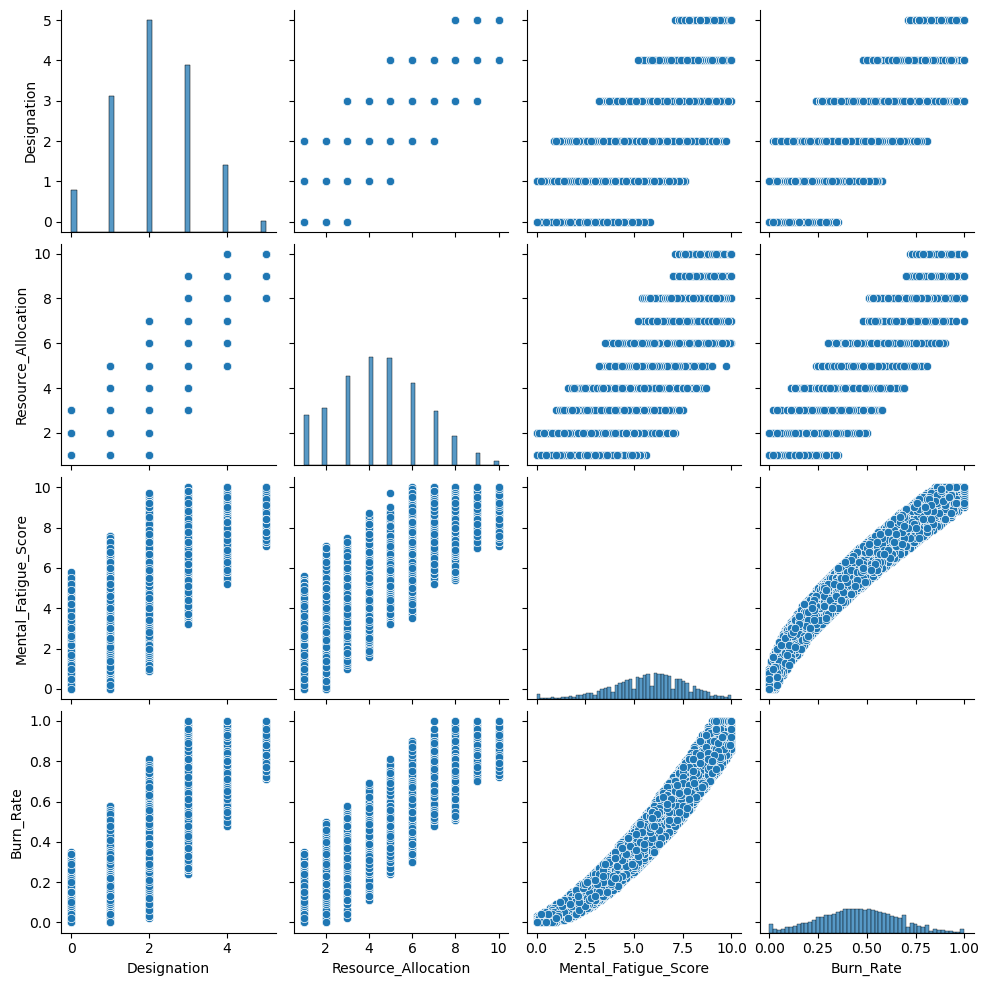

In [6]:
sns.pairplot(pf)

In [7]:
pf = pf.dropna()
len(pf)

18590

Out of 22750 we have 18590 to check Type of data is each variable.

Categorical features

In [8]:
pf.dtypes

Employee_ID              object
Date_of_Joining          object
Gender                   object
Company_Type             object
WFH_Setup_Available      object
Designation               int64
Resource_Allocation     float64
Mental_Fatigue_Score    float64
Burn_Rate               float64
dtype: object

In [9]:
pf_obj = pf.select_dtypes(object)
print({ c : pf_obj[c].unique()[:10] for c in pf_obj.columns})

{'Employee_ID': array(['fffe32003000360033003200', 'fffe3700360033003500',
       'fffe32003400380032003900', 'fffe31003900340031003600',
       'fffe3300350037003500', 'fffe33003300340039003100',
       'fffe32003600320037003400', 'fffe33003100330032003700',
       'fffe3400310035003800', 'fffe33003100330036003300'], dtype=object), 'Date_of_Joining': array(['30-09-2008', '30-11-2008', '03-11-2008', '24-07-2008',
       '26-11-2008', '02-01-2008', '31-10-2008', '16-03-2008',
       '12-05-2008', '14-05-2008'], dtype=object), 'Gender': array(['Female', 'Male'], dtype=object), 'Company_Type': array(['Service', 'Product'], dtype=object), 'WFH_Setup_Available': array(['No', 'Yes'], dtype=object)}


In [10]:
pf = pf.drop("Employee_ID", axis=1)
pf.head().T

,0,1,3,4,5
Date_of_Joining,30-09-2008,30-11-2008,03-11-2008,24-07-2008,26-11-2008
Gender,Female,Male,Male,Female,Male
Company_Type,Service,Service,Service,Service,Product
WFH_Setup_Available,No,Yes,Yes,No,Yes
Designation,2,1,1,3,2
Resource_Allocation,3.0,2.0,1.0,7.0,4.0
Mental_Fatigue_Score,3.8,5.0,2.6,6.9,3.6
Burn_Rate,0.16,0.36,0.2,0.52,0.29


Data distribution

Min date 01-01-2008
Max date 31-12-2008


<Axes: xlabel='Month', ylabel='Hired employees'>

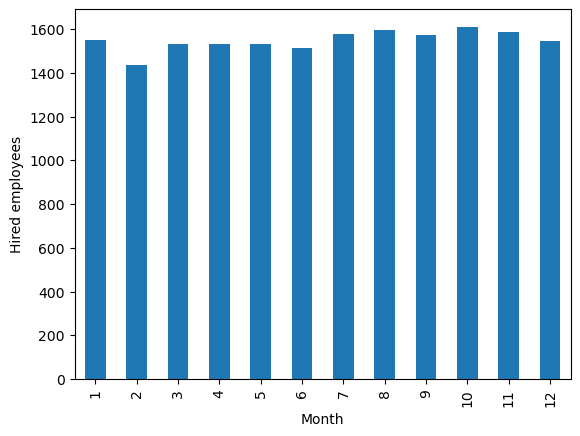

In [11]:
print(f"Min date {pf.Date_of_Joining.min()}")
print(f"Max date {pf.Date_of_Joining.max()}")
pf_month = pf.copy()

pf_month["Date_of_Joining"] = pf_month.Date_of_Joining.astype("datetime64[ns]")
pf_month.Date_of_Joining.groupby(
        pf_month.Date_of_Joining.dt.month
    ).count().plot(kind="bar", xlabel='Month', ylabel = "Hired employees")

Count the days from 01-01-2008 until the date of joining 

In [12]:
dt_2008 = pd.to_datetime(["01-01-2008"]*len(pf))
pf["Days"] = pf.Date_of_Joining.astype("datetime64[ns]").sub(dt_2008).dt.days
pf.Days

0        273
1        334
3         70
4        205
5        330
        ... 
22743    349
22744    147
22746     18
22748    274
22749    152
Name: Days, Length: 18590, dtype: int64

Extracting specific correlation values, excluding "Burn_Rate" itself

In [13]:
if "Burn_Rate" in correlation_matrix.columns:
    burn_rate_correlation = correlation_matrix["Burn_Rate"].drop(labels=["Burn_Rate"], errors="ignore")

print(burn_rate_correlation)

Designation             0.737556
Resource_Allocation     0.856278
Mental_Fatigue_Score    0.944546
Name: Burn_Rate, dtype: float64


In [14]:
pf = pf.drop(["Date_of_Joining", "Days"], axis=1)
pf.head().T

,0,1,3,4,5
Gender,Female,Male,Male,Female,Male
Company_Type,Service,Service,Service,Service,Product
WFH_Setup_Available,No,Yes,Yes,No,Yes
Designation,2,1,1,3,2
Resource_Allocation,3.0,2.0,1.0,7.0,4.0
Mental_Fatigue_Score,3.8,5.0,2.6,6.9,3.6
Burn_Rate,0.16,0.36,0.2,0.52,0.29


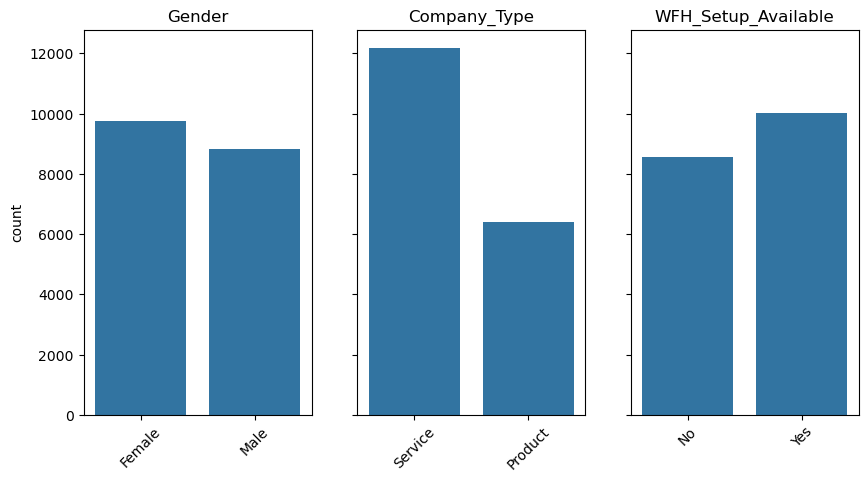

In [15]:
cat_columns = pf.select_dtypes(object).columns
fig, ax = plt.subplots(nrows=1, ncols=len(cat_columns), sharey=True, figsize=(10,5))

for i, c in enumerate(cat_columns):
    sns.countplot(x=pf[c], ax=ax[i])  
    ax[i].set_title(c)  
    ax[i].tick_params(axis='x', rotation=45)  
    ax[i].set_xlabel("")  

plt.show()

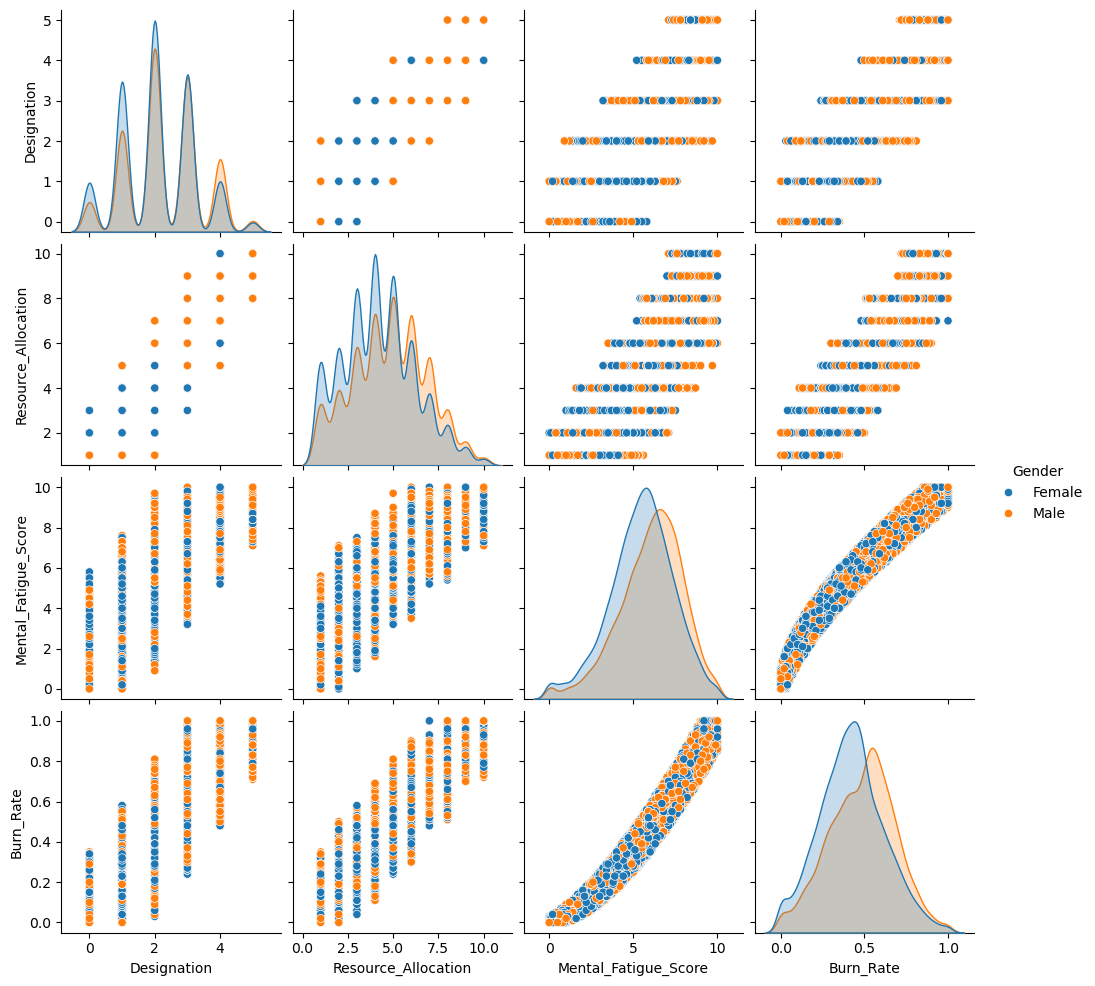

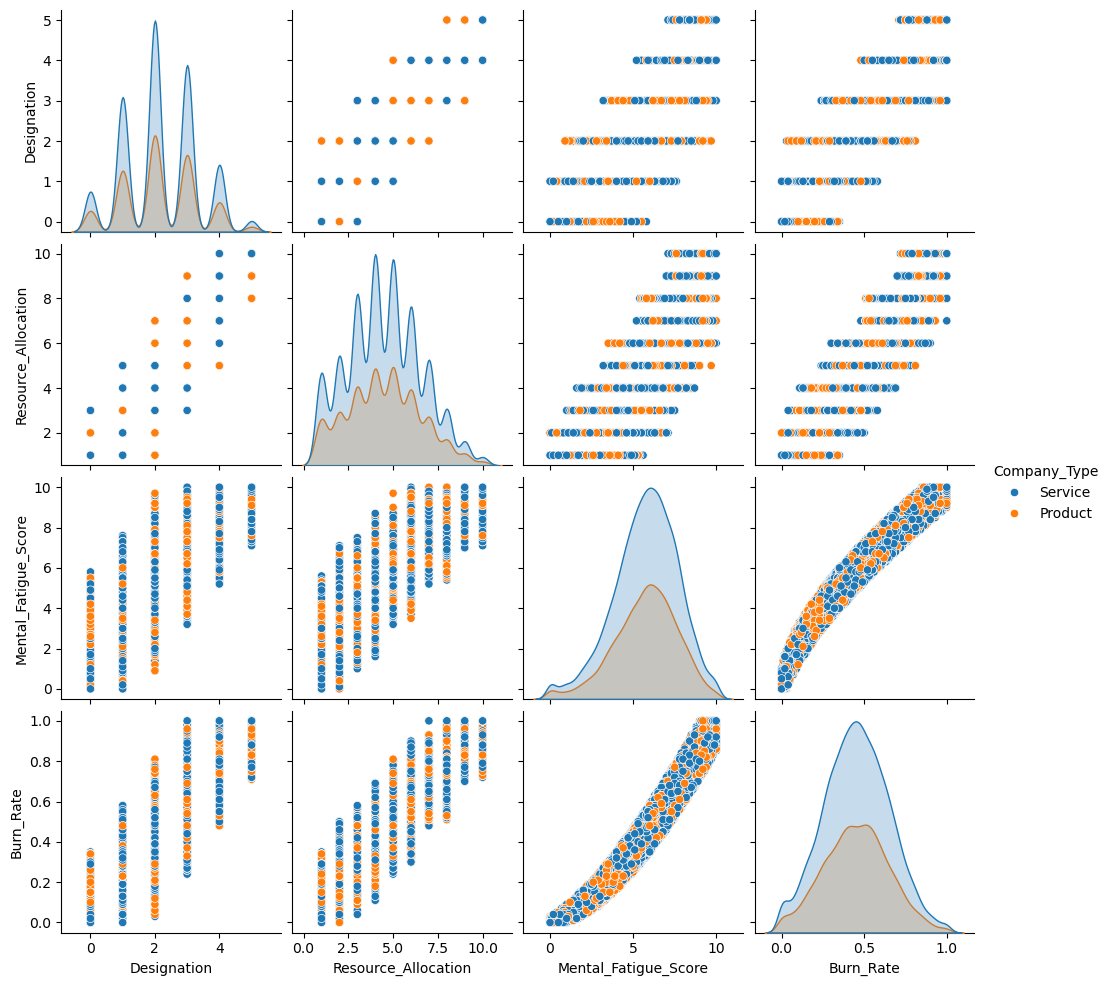

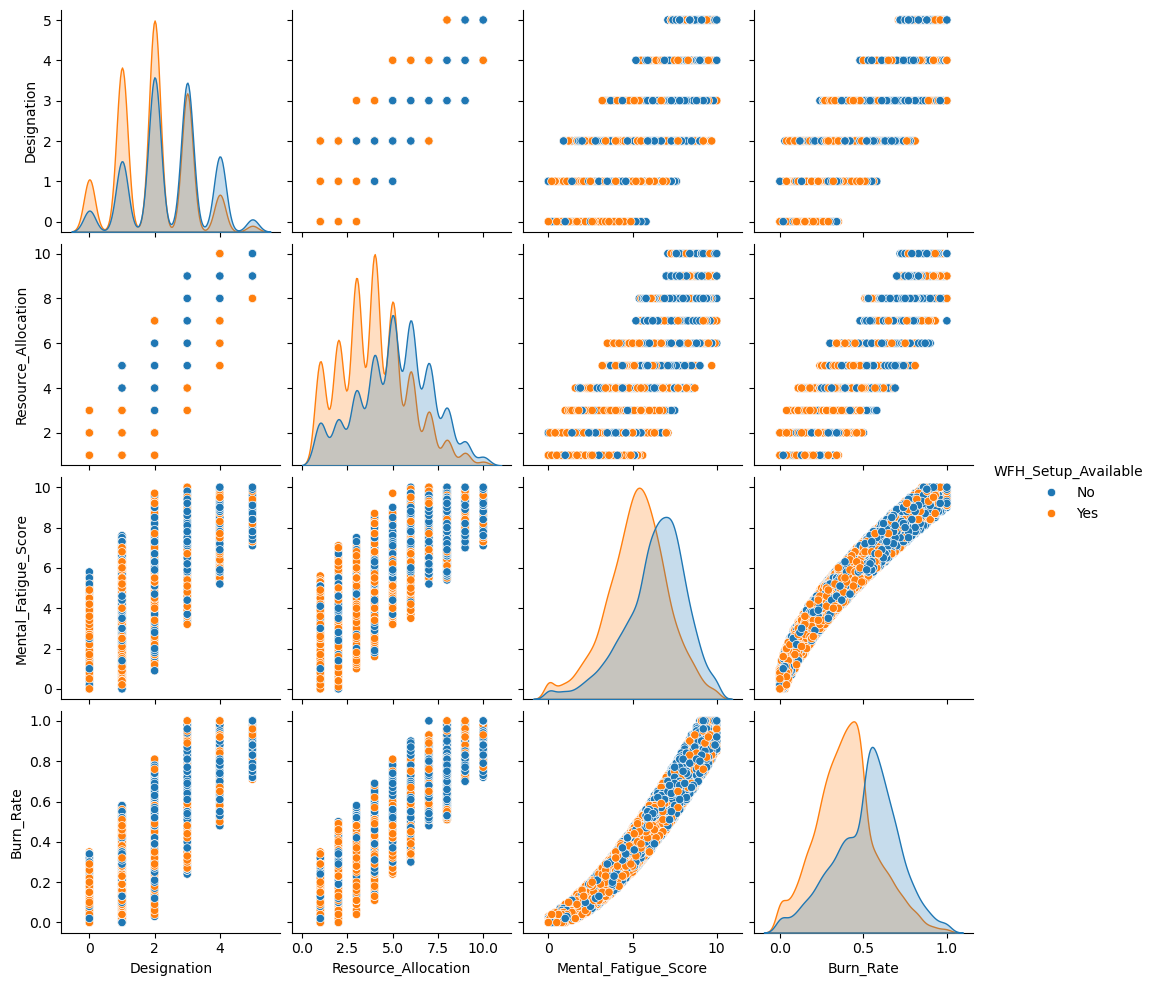

In [16]:
for c in pf.select_dtypes(object).columns:
    sns.pairplot(pf, hue=c)
plt.show()

In [17]:
for c in pf.select_dtypes(exclude=object):
    print(f"{c}: (p-value = {normaltest(pf[c])[1]})")

Designation: (p-value = 7.799535630459232e-52)
Resource_Allocation: (p-value = 9.214167946666707e-96)
Mental_Fatigue_Score: (p-value = 6.8137251483124435e-124)
Burn_Rate: (p-value = 1.0375928238178144e-16)


Variables are normally distributed since all p-values<.05.

Since all our categorical features are binary, and we don't want to represent multilinearity in our data, this classes can be represented
with one dimension for each feature.

In [18]:
pf = pd.get_dummies(pf, columns=["Company_Type", "WFH_Setup_Available", "Gender"], drop_first=True)
pf.head().T

,0,1,3,4,5
Designation,2,1,1,3,2
Resource_Allocation,3.0,2.0,1.0,7.0,4.0
Mental_Fatigue_Score,3.8,5.0,2.6,6.9,3.6
Burn_Rate,0.16,0.36,0.2,0.52,0.29
Company_Type_Service,True,True,True,True,False
WFH_Setup_Available_Yes,False,True,True,False,True
Gender_Male,False,True,True,False,True


Now, dataframe doesn't have non-numeric values and all previous them are represented with just a numeric column. Before continuing to use data pipelines and models to fit  data, first to split our dataframe in our input features X and target value y.

X and y data

In [19]:
y_col = 'Burn_Rate'
pf.columns
X = pf[[c for c in pf.columns if c != y_col]]
y = pf[y_col]

print(X.shape)
print(y.shape)

(18590, 6)
(18590,)


# Pipeline  models  and  Machine  Learning 

Create data pipelines with models to find which one perform better on data.  
the models that we are going to use are:

Linear Regression 

Lasso Regression

Ridge Regression 

In [20]:
def create_pipeline(model_name: str, model_params: Dict):
    
    model = getattr(linear_model, model_name)()
    estimator = Pipeline([
            ("polynomial_features", PolynomialFeatures()),
            ("scaler", StandardScaler()),
            (model_name, model)])

    params = {
        'polynomial_features__degree': [1, 2],
    }
    params.update(
        { model_name + "__" + k : v for k,v in model_params.items()}
    )
    return estimator, params

In [21]:
results = {}

for name, params in {
    "LinearRegression": {},
    "Lasso": { "alpha" : np.geomspace(0.0001, 0.001, 50)},
    "Ridge": { "alpha" : np.geomspace(10, 15, 50)},
}.items():
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    estimator, params = create_pipeline(name, params)
    
    grid = GridSearchCV(estimator, params, cv=kf,
                        scoring = make_scorer(r2_score), n_jobs=4)
    result = grid.fit(X, y)

    print(name)
    print("="*len(name))
    print("Params:")
    print(result.best_params_)
    print(f"R2 score: {result.best_score_}")
    print()
    
    results[name] = result

LinearRegression
Params:
{'polynomial_features__degree': 2}
R2 score: 0.9242522651376269

Lasso
=====
Params:
{'Lasso__alpha': 0.00011513953993264469, 'polynomial_features__degree': 2}
R2 score: 0.9242902867272779

Ridge
=====
Params:
{'Ridge__alpha': 10.0, 'polynomial_features__degree': 2}
R2 score: 0.924255828294104



In [22]:
estimator = deepcopy(results["Lasso"].best_estimator_)

estimator.fit(X, y)
print(r2_score(y, estimator.predict(X)))

0.924516995662191


Interpretation

In order to see which input features are most important for predicting the Burn Rate, analyze the coefficients of the models.

In [23]:
pf_coefs = pd.DataFrame()
for model_name, result in results.items():
    pf_coefs[model_name+"_Coefficients"] = result.best_estimator_[-1].coef_

pf_coefs_stats = pf_coefs.describe()
pf_coefs_stats.rename({'50%': 'median'}, inplace=True)
pf_coefs_stats

,LinearRegression_Coefficients,Lasso_Coefficients,Ridge_Coefficients
count,28.000000,28.000000,28.000000
mean,0.007020,0.006955,0.006989
std,0.024772,0.022539,0.022976
min,-0.035259,-0.002382,-0.016258
25%,-0.001042,-0.000168,-0.000935
median,0.000428,-0.000000,0.000296
75%,0.002389,0.000843,0.001890
max,0.113684,0.113364,0.112173


In [24]:
estimator = results["Lasso"]
coefs = estimator.best_estimator_[-1].coef_
pf_names = estimator.best_estimator_[0].get_feature_names_out(X.columns)
pf_names = [col.replace(" ", " * ") for col in pf_names]

print("Total Coefficients: ", len(coefs))
print("Number of zero-value coefficients: ", (coefs==0).sum())

Total Coefficients:  28
Number of zero-value coefficients:  11


11 polynomial features of the 28 doesn't have any predictive power for our problem.

In [25]:
pf_coefs = pd.DataFrame(coefs).T
pf_coefs.columns = pf_names
pf_coefs.T.sort_values(0, ascending=False)

,0
Mental_Fatigue_Score,0.113364
Resource_Allocation,0.030879
Mental_Fatigue_Score^2,0.030052
Resource_Allocation^2,0.016243
Resource_Allocation * Mental_Fatigue_Score,0.009086
Company_Type_Service * Gender_Male,0.001660
Gender_Male,0.001080
Mental_Fatigue_Score * Gender_Male,0.000765
Gender_Male^2,0.000008
Designation * Mental_Fatigue_Score,-0.000000


# Conclusion

The project successfully developed a regression model to predict employee burnout using features like mental fatigue score, work-from-home status, and workload. Key steps included handling missing values, encoding categorical data, studying feature correlations, and applying advanced techniques such as grid search cross-validation and polynomial features. The model's performance was evaluated using the $ R² metric $ , demonstrating its potential to help organizations proactively address employee burnout and promote well-being.

Thank you !